<a href="https://colab.research.google.com/github/AnnaITI/Data-Compression-/blob/main/Lab1_GTI771.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Laboratoire 1 - Analyse et préparation des données et extraction de primitives
### GTI771 - Apprentissage machine avancé
#### Département du génie logiciel et des technologies de l’information

#### Version 1.0 janvier 2020
#### <font color=blue> Version 2.0 janvier 2020 </font>
#### <font color=green> Version 3.0 février 2020 </font>

##### Prof. Alessandro L. Koerich

| Étudiants             | PINEAU(PINA15569906) - BONA - GAILLOTTE                               |
|-----------------------|---------------------------------------------------------|
| Session               | Automne 2021                                           |
| Équipe                | 12                                                      |
| Numéro du laboratoire | 1                                                       |
| Professeur            | Prof. NOM                                               |
| Chargé de laboratoire | Antoine Tönz                                                     |
| Date                  | 10 sept 2021                                            |

## Introduction

Ce premier laboratoire porte sur la définition et l’extraction de primitives sur des visages. Le problème de classification qui vous est présenté est le problème [Facial Expression Recognition (FER)](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data), dont le but est de classer des visages dans sept catégories. En vous basant sur les concepts vus en classe, vous devez définir des primitives que vous jugez pertinentes à extraire sur ces types d’images et effectuer l’extraction de celles-ci sur l’ensemble de données fournies avec cet énoncé.

Veuillez noter que les images qui vous sont fournies ne sont pas nécessairement très faciles à travailler. Plusieurs images comportent du bruit, des artéfacts ou des éléments non pertinents. Le défi de ce laboratoire repose sur cette difficulté qui est chose courante dans des problèmes d’apprentissage machine moderne.

Voici, en exemple, des images de visages se retrouvant dans l’ensemble de données:

![Exemples de FER](https://miro.medium.com/max/2420/1*nXqJ4lMiBRp4Ilm3bpRxuA.png)


L’évaluation de ce laboratoire sera basée sur la qualité des primitives proposées, les réponses aux questions dans cette notebook ainsi que l'organisation de votre code source <font color=blue> (SVP, n'oubliez pas des commentaires dans le code!)</font>. Le pouvoir discriminant, c’est-à-dire la capacité des primitives à bien séparer les exemples des classes dans l’espace des primitives, sera également évalué.

## Partie 1: Imports

#### (1a) Import de bibliotèques

##### À faire:
1. Ajouter toutes les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [ ]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
# Votre code ici
import cv2 

from scipy import ndimage as nd
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


## Partie 2: Analyse exploratoire des données

On va commencer en regardant les données.

Pour ce lab, nous allons utiliser le dataset FER.

Le dataset est disponible dans https://www.kaggle.com/ahmedmoorsy/facial-expression, et il continent presque 35,000 visages.

### (2a) Charger le fichier de données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data
ferData = np.loadtxt( '/content/drive/MyDrive/GTI771/fer2013.csv', delimiter=',', dtype=np.str )
 
# Training set
Xtrain = np.ones( (28709,2304), np.uint8 )

for i in range( 1, 28710 ):
    Xtrain[i-1] = ferData[i,1].split(" ")

ytrain = ferData[1:28710,0].astype( np.int )

# Validation set
Xval = np.ones( (3589,2304), float )

for i in range( 28710, 32299 ):
    Xval[i-28710] = ferData[i,1].split(" ")

yval = ferData[28710:32299,0].astype( np.int )

# Test set
Xtest = np.ones( (3589,2304), float )

for i in range( 32299, 35888 ):
    Xtest[i-32299] = ferData[i,1].split(" ")

ytest = ferData[32299:,0].astype( np.int )

print(Xtrain.shape, Xval.shape, Xtest.shape)

(28709, 2304) (3589, 2304) (3589, 2304)


In [ ]:
# reshape to be [samples][channels][width][height]
Xtrain = Xtrain.reshape( Xtrain.shape[0], 1, 48, 48 ).astype('uint8')
Xtest  = Xtest.reshape( Xtest.shape[0], 1, 48, 48 ).astype('uint8')
Xval   = Xval.reshape( Xval.shape[0], 1, 48, 48 ).astype('uint8')

print( Xtrain.shape, Xval.shape, Xtest.shape )

(28709, 1, 48, 48) (3589, 1, 48, 48) (3589, 1, 48, 48)


### <font color=blue> (2b) Visualisation des visages </font>

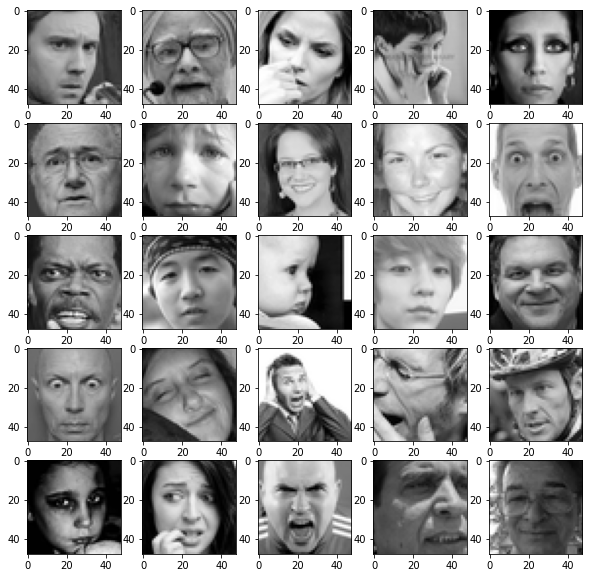

In [ ]:
nombre_image_visualiser = 25 

plt.figure(figsize = (10,10))

for i in range(nombre_image_visualiser): 
  plt.subplot(5,5,i+1)
  plt.imshow(cv2.cvtColor(Xtrain[i].copy().reshape(48,48), cv2.COLOR_BGR2RGB))

plt.show()

Pensez-vous qui c'est necessaire un pre-traitement des images? Si oui, 
[Pre-processing](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)

_Réponse_ : Non, un pré-traitement des images n'est pas nécessaire car les images ne paraissent pas bruitées ni incomplètes. Les images semblent pixelisées mais cela est du à l'aggrandissement effectué lors de l'affichage par l'option _figsize_.

Cependant selon le tps, certaines images contiennent des éléments non pertinents. Nous allons donc d'abord vérifier si certaines images nécessitent une normalisation (histogramme soit bien compris entre 0 et 255) puis nous allons étudier plus en détails les images qui ont plus de 90% de leur donnée sur la même nuance de gris. 


In [ ]:
for i in range(Xtrain.shape[0]):
    if (np.any(Xtrain[i][0]))>255 or np.any(Xtrain[i][0])<0 :
        plt.imshow(cv2.cvtColor(Xtrain[i][0].copy().reshape(48,48), cv2.COLOR_BGR2RGB))
        plt.show()

# Il n'y a pas d'images avec des valeurs hors des limites (0 et 255)

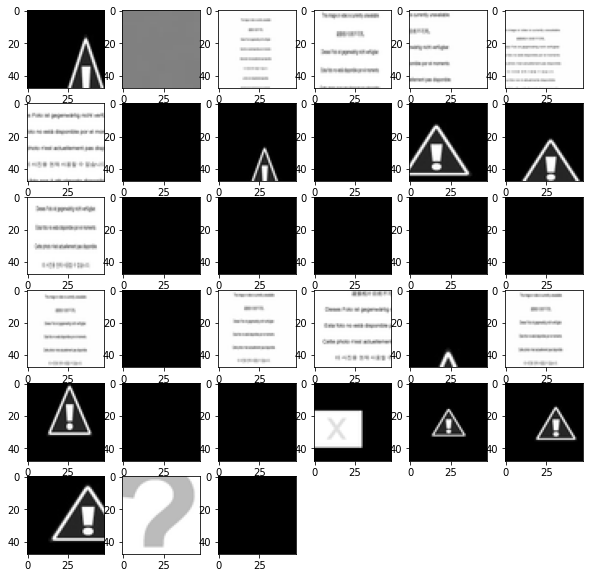

In [ ]:
from collections import Counter

def rechercher_images_eronnees(Xtrain, seuil = 0.5): 
  h = 0
  list_images_eronnees = []
  plt.figure(figsize = (10,10))

  for i in range(Xtrain.shape[0]):
      if (Counter(Xtrain[i][0].copy().flatten().tolist()).most_common(1)[0][1]/(48*48))> seuil:
          h += 1
          list_images_eronnees.append(i)
          plt.subplot(6,6,h)
          plt.imshow(cv2.cvtColor(Xtrain[i].copy().reshape(48,48), cv2.COLOR_BGR2RGB))

  plt.show()
  return list_images_eronnees

list_images_eronnees = rechercher_images_eronnees(Xtrain)

# Il y a une trentaine d'images eronnées à retirer de la liste 

In [ ]:
# On fait une copie de notre training set pour éviter de modifier le 
# data set initial 
Xtrain_new = Xtrain.copy()
ytrain_new = ytrain.copy()

# On trie la liste du plus grand au plus petit pour éviter à chaque suppression d'image 
# que l'index se décale.
list_images_eronnees.sort(reverse=True)

# On retire les images éronnées
for each in list_images_eronnees : 
  Xtrain_new = np.delete(Xtrain_new, each, 0)
  ytrain_new = np.delete(ytrain_new, each, 0)

In [ ]:
# On vérifie que les images ont bien été retiré :
assert not rechercher_images_eronnees(Xtrain_new), 'KO le processus d effacement d images n est pas fonctionnel' 

<Figure size 720x720 with 0 Axes>

### (2b) Statistiques des données

##### À faire:
1. Calculer quelques statistiques (moyenne, écart-type, etc.) que vous jugez importantes sur les données (entrées et sorties)
2. Faire une analyse des résultats et présenter vos conclusions sur ces statistiques.

### Partie 2b: Code:

In [ ]:
# Votre code ici

# Histogramme des étiquettes
hist, _ = np.histogram(Xtrain[0][0], density=False, bins=7, range=(0, 7))

#Moyenne et variance de Xtrain :


Xtrain_global_mean = np.mean(Xtrain)
Xtrain_gloabal_std = np.std(Xtrain)

Xtrain_mean  = []
Xtrain_std = []
for image in Xtrain:
  Xtrain_mean.append(np.mean(image))
  Xtrain_std.append(np.std(image))

#Moyenne par groupe

Xtrain_groupe_mean = [[],[],[],[],[],[],[]]
Xtrain_groupe_std = [[],[],[],[],[],[],[]]

for index, image in enumerate(Xtrain):
  Xtrain_groupe_mean[ytrain[index]].append(np.mean(image))
  Xtrain_groupe_std[ytrain[index]].append(np.mean(image))

for i in range(len(Xtrain_groupe_mean)):
  Xtrain_groupe_mean[i]=np.mean(Xtrain_groupe_mean[i])
  Xtrain_groupe_std[i]=np.mean(Xtrain_groupe_std[i])


### Partie 2b: Résultats et résponses:

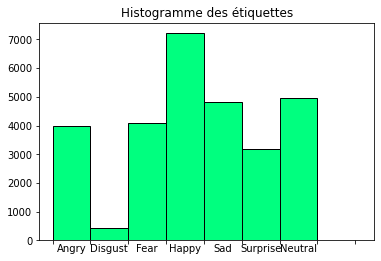

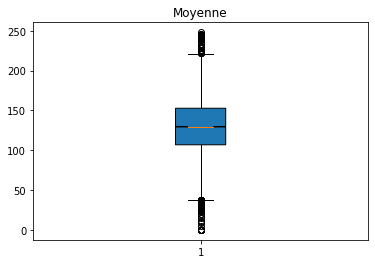

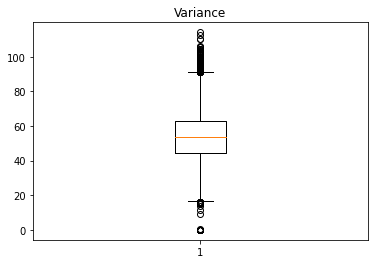

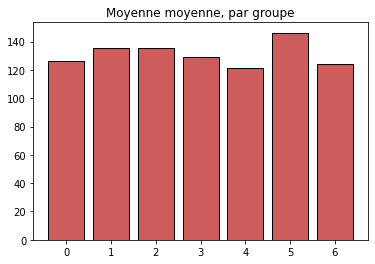

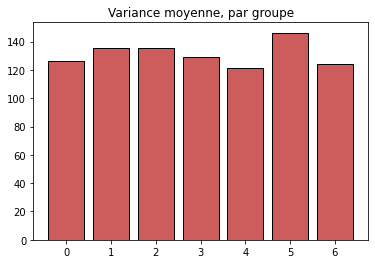

In [ ]:
# Vos résultats ici:

# Plot du histogramme

fig, ax = plt.subplots()

ax.hist(ytrain, bins = [0,1,2,3,4,5,6,7], color='springgreen',edgecolor='black') 

ax.set_xticklabels([])
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
mticks = ax.get_xticks()
ax.set_xticks((mticks[:-1]+mticks[1:])/2+1, minor=True)
ax.tick_params(axis='x', which='minor', length=0)
ax.set_xticklabels(labels, minor=True)
plt.title("Histogramme des étiquettes")
plt.show()

#Affichage boite à moustache de la moyenne des images

plt.boxplot(Xtrain_mean,patch_artist=1, notch=True)
plt.title("Moyenne")
plt.show()

#Affichage boite à moustache de la variance des images

plt.boxplot(Xtrain_std)
plt.title("Variance")
plt.show()

#Affichage de la valeur moyenne des images par groupe
plt.bar([0,1,2,3,4,5,6],Xtrain_groupe_mean, color='indianred',edgecolor='black')
plt.title("Moyenne moyenne, par groupe")
plt.show()

#Affichage de la variance moyenne des images par groupe
plt.bar([0,1,2,3,4,5,6],Xtrain_groupe_std, color='indianred',edgecolor='black')
plt.title("Variance moyenne, par groupe")
plt.show()






Conclusions statistiques :



*   Dans notre dataset nous avons un grand nombre d'image représentant l'émotion "Happy". En revanche nous n'avons que très peu d'image représentant "disgust" ce qui va rendre la classification plus complexe pour cette classe. Le reste des émotions est représentée de facon assez homogène.
*   L'étude statistique de notre dataset nous permet de remarquer que l'émotion "surprise" se démarque des autres émotions, les images de cette classes ont une valeur moyenne plus élevée que les images d'autres classes mais aussi une variance plus élevée. On peut donc conclure que pour cette classe les images sont assez différentes les unes des autres ce qui peut rendre la classifications dans cette classe plus compliquée. 
*   Autrement nos données ont le même ordre de grandeur en variance et en moyenne.





### (2c) Créer et évaluer un modèle de base (baseline)

Un modèle très simple, mais naturel est une ou nous calculons un modèle moyen (template) pour chaque classe (sur les données d'apprentissage) et nous utilisons ces modèles (templates) pour faire des prédictions sur des nouvelles données.

##### À faire:
1. Créer un template pour chaque classe
2. Faire un plot de chaque template <font color=blue> (visage moyen) </font>
3. Classifier tous les exemples (ensembles d'apprentissage, validation et test) et reporter les résultats:<br>
 3a. taux de classification correct sur les trois (3) ensembles de données<br>
 3b. matrice de confusion pour les résultas sur l'ensemble de test
4. Faire une analyse des résultats et présenter vos conclusions sur ce modèle

### Partie 2c: Code:

In [ ]:
sum = 0
groupby_number = dict()

for each in np.unique(ytrain): 
  print(Xtrain[ytrain == each].shape)
  groupby_number.update({each : Xtrain[ytrain == each]})

  sum += Xtrain[ytrain == each].shape[0]

# Vérifie que la somme de chaque sous groupe correspond bien à la taille du groupe entier 
assert sum == Xtrain.shape[0], 'KO sum does not correspond'

(3995, 1, 48, 48)
(436, 1, 48, 48)
(4097, 1, 48, 48)
(7215, 1, 48, 48)
(4830, 1, 48, 48)
(3171, 1, 48, 48)
(4965, 1, 48, 48)


In [ ]:
def creation_visage_moyen(emotion_number, groupby_number,taille_image = 48) : 
  visage_moyen = []
  
  list_images = [img[0].flatten() for img in groupby_number[emotion_number]]

  for i in range(48*48) :
    list_pixel = [pixel[i] for pixel in list_images]
    visage_moyen.append(np.mean(list_pixel))

  visage_moyen = np.array(visage_moyen)
  visage_moyen.reshape(48,48)
  return visage_moyen


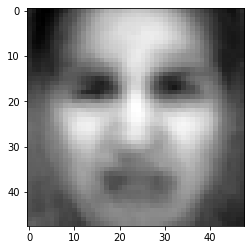

In [ ]:
visage_moyen_groupe_1 = creation_visage_moyen(1, groupby_number)
plt.imshow(visage_moyen_groupe_1.copy().reshape(48,48),cmap = 'gray')

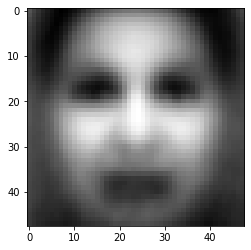

In [ ]:
visage_moyen_groupe_2 = creation_visage_moyen(2, groupby_number)
plt.imshow(visage_moyen_groupe_2.copy().reshape(48,48),cmap = 'gray')

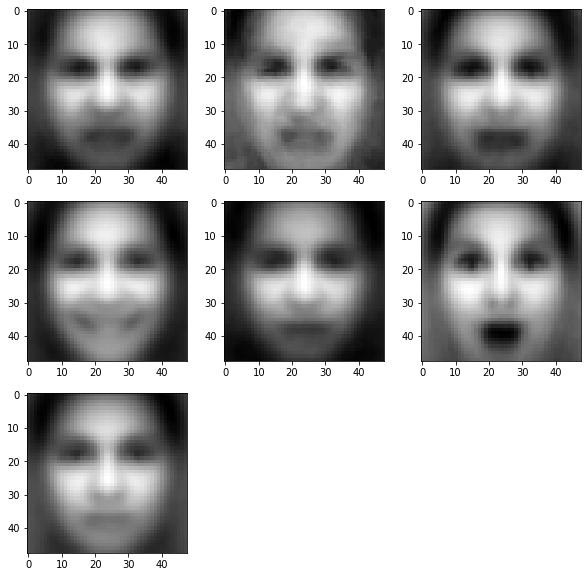

In [ ]:
i = 0
list_visage_moyen = []
plt.figure(figsize = (10,10))

for each in np.unique(ytrain) :
  i += 1
  visage_moyen = creation_visage_moyen(each, groupby_number)

  plt.subplot(3,3,i)
  plt.imshow(visage_moyen.copy().reshape(48,48),cmap = 'gray')

  list_visage_moyen.append(visage_moyen)


plt.show()

### Partie 2c: Résultats et résponses:

In [ ]:
def classification_image(Xtrain,ytrain,list_visage_moyen): 
  list_classification_visages = list()

  for each in Xtrain :
    list_classification_visage = list()

    for j in range(len(list_visage_moyen)) :
      list_classification_visage.append(np.mean(abs(each[0].flatten() - list_visage_moyen[j])))

    list_classification_visages.append(np.argmin(list_classification_visage))

  return len(ytrain[ytrain == list_classification_visages])/len(ytrain)

In [ ]:
classification_image(Xtrain,ytrain,list_visage_moyen)

0.2074262426416803

In [ ]:
classification_image(Xval,yval,list_visage_moyen)

0.21036500417943718

In [ ]:
classification_image(Xtest,ytest,list_visage_moyen)

0.2148230704931736

In [ ]:
# Vos résultats ici:

## Partie 3: Extraction de primitives

Vous devez faire une recherche bibliographique pour trouver quelles sont les primitives qui sont plus souvent utilisées pour la reconnaissance des expressions faciales. Voici quelques sources et mot-clés pour guider votre recherche:

- https://doi.org/j.imavis.2008.08.005
- http://www.inf.ufpr.br/lesoliveira/download/ESWA2013.pdf
- https://doi.org/10.1016/j.patrec.2015.06.007 
- https://doi.org/10.1109/FG.2011.5771374


##### mots-clés: facial expression recognition, facial emotion recognition.


### Bibliotèques Python pour l'extraction de primitives

* [Scikit-image](https://scikit-image.org/docs/dev/)
* [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html)
* [Scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html)

### Primitives candidates

* LBP, LPQ, Gabor filters, SIFT, SURF, HOG, GLCM, Haralick Moments, etc.

### (3a) Extraire des primitives

##### À faire:
1. Choisir au moins deux (2) ensembles de primitives et extraire ces primitives des visages (ensembles d'apprentissage, validation et test)
2. Choisir des paires de primitives et tracer un graphique 2D (données d'apprentissage) pour visualiser si ces primitives sont capables de bien séparer les sept (7) classes.
3. <font>Sauvegarder vos vecteurs de primitives dans des fichiers '.csv'. Utiliser la même structure du fichier FER3013, où nous avons dans un seul fichier, séquentiellement, les trois partitions: apprentissage (0-28709), validation (28710-32299) et test (32299, 35888). Nommer vos fichiers de primitive en référence à la primitive utilisée. Ex: lbp83_fer2013.csv </font> 
4. Faire une analyse des résultats et présenter vos conclusions sur ces primitives.

### Partie 3a: Code:

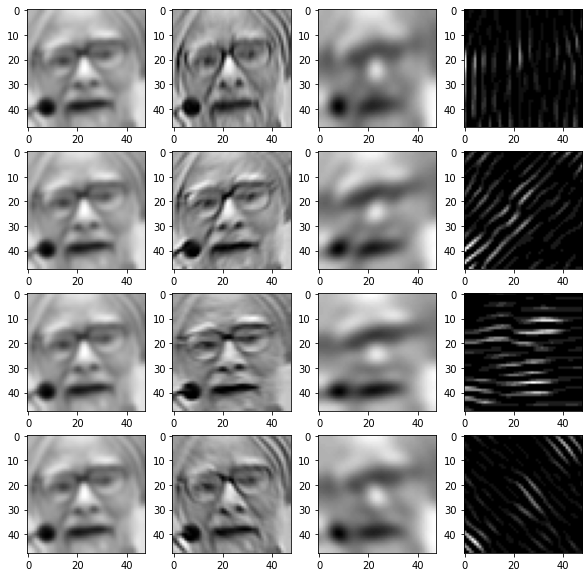

In [ ]:
''' Code pris sur la bibliothèque scikit-image à 
l'adresse : https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html#sphx-glr-auto-examples-features-detection-plot-gabor-py, 
le 17/09/2021 
''' 


kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

plt.figure(figsize=(10,10))
for k,kernel in enumerate(kernels) :
  plt.subplot(4,4,k+1)
  plt.imshow(cv2.filter2D(Xtrain[1][0], cv2.CV_8UC3, kernel),cmap= 'gray')

plt.show()


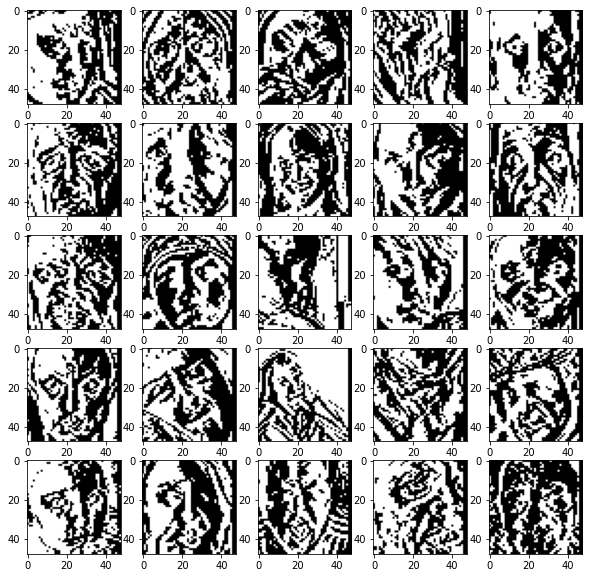

In [ ]:
''' Code pris sur la bibliothèque scikit-image à 
l'adresse : https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html, 
le 17/09/2021 
''' 

from skimage.transform import rotate
from skimage.feature import local_binary_pattern

nombre_image_visualiser = 25 

plt.figure(figsize = (10,10))

for i in range(nombre_image_visualiser): 
  plt.subplot(5,5,i+1)
  plt.imshow(local_binary_pattern(Xtrain[i][0],1,2),cmap = 'gray') 

plt.show()

### Partie 3a: Résultats et résponses:

In [ ]:
# Vos résultats ici:

## Partie 4: Construction d'un modèle

<font color=blue>Nous sommes maintenant prêtes pour entraîner notre premier modèle avec les primitives extraites dans la partie 3. On suppose que vous avez deux jeux de primitives, alors vous devez entraîner un modèle pour chaque jeu de primitives.</font>

### (4a) Entraîner un modèle

Vous devez choisir un des algorithmes d'apprentissage suivants et l'entraîner sur les données d'apprentissage (même algorithme pour les deux jeux de primitives):<br>
* [Decision trees](https://scikit-learn.org/stable/modules/tree.html) de scikit-learn. <br>
* [k-NN](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) de scikit-learn. <br>
* [Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) de scikit-learn. 

<font color=blue>Pour ce premier modèle, vous n'est pas supposé de régler (optimiser) votre modèle. Vous allez faire ce réglage dans la partie (4b).</font>

Après l'entraînement, vous devez faire des prédictions sur les données de test.

##### À faire:
1. Entraîner un modèle avec l'algorithme d'apprentissage choisi
2. Classifier tous les exemples (ensembles d'apprentissage, validation et test) et reporter les résultats:<br>
 2a. taux de classification correct sur les trois (3) ensembles de données<br>
 2b. matrice de confusion pour l'ensemble de test
3. <font color=blue>Sauvagarder votre modèle dans un fichier. Regarder [model persistence](https://scikitlearn.org/stable/modules/model_persistence.html?highlight=persistence) </font> 
4. Expliquer pourquoi vous avez choisi cet algorithme d'apprentissage (Q1).
5. Faire une analyse des résultats et présenter vos conclusions sur le modèle entraîné (Q2).
6. Concernant vos primitives, sont-elles discriminantes? (Q3)

### Partie 4a: Code:

In [ ]:
# Votre code ici

### Partie 4a: Résultats et résponses:

#### Vos résultats ici:

##### Exemple:

| Ensemble | Taux de classification correct |                               
|----------|--------------------------------|
| App      | 99,67%                         |                   
| Val      | 89,77%                         |                             
| Test     | 77,99%                         |        

Q1: Nous avons choisi l'algorithme d'arbre de décision parce que...

Q2: Les taux de classification indiquent que le modèle...

Q3: La performance avec le primitive...

### (4b) Réglage du modèle

Probablement vous avez outperformé le modèle << baseline >>, mais est-ce qu'on peut mieux performer? Est-ce qu'on peut faire un << fine-tuning >> de notre modèle? Quels sont les paramètres que vous pouvez ajuster pour améliorer la performance?

##### À faire:
1. Lister les principaux paramètres de votre modèle qui peuvent aider à améliorer sa performance.
2. Choisir quelques paramètres (au moins 2) et tourner un << grid search>> pour trouver les meilleures valeurs pour ces paramètres.
3. Une fois que vous avez trouvé le meilleur modèle, utiliser ce modèle pour classifier tous les exemples (apprentissage, validation, test) et reporter les résultats:<br>
 3a. taux de classification correct sur les 3 ensembles<br>
 3b. matrice de confusion pour l'ensemble de test
4. Explique pourquoi vous avez choisi ces paramètres.
5. Faire une analyse des résultats et présenter vos conclusions sur ce modèle << fine- tuned >>

### Partie 4b: Code:

In [ ]:
# Votre code ici

### Partie 4b: Résultats et résponses:

In [ ]:
# Vos résultats ici:

## Partie 5: Réduction de la dimensionnalité

### Bibliotèques Python pour la reduction de la dimensionnalité

* [Transformation algorithms](https://scikit-learn.org/stable/modules/decomposition.html#decompositions)
* [Feature selection algorithms](https://scikit-learn.org/stable/modules/feature_selection.html)

##### À faire:
1. Choisir un algorithme de transformation de primitives et un algorithme de sélection des primitives et réduire la dimensionnalité de vos vecteurs de primitives (Partie 3).
2. Choisir les deux meilleures primitives et ploter un graphique pour visualiser si ces primitives sont capables de bien séparer les sept (7) classes.
3. Faire une analyse des résultats et présenter vos conclusions sur ces primitives.

### Partie 5a: Code:

In [ ]:
# Votre code ici

### Partie 5a: Résultats et résponses:

In [ ]:
# Vos résultats ici:

### (5b) Rentraîner le modèle de la partie 4a

Vous devez rentraîner le modèle et l'entraîner sur les données d'apprentissage.<br>
Après l'entraînement, vous devez faire des prédictions sur les données de test.

### Partie 5b: Code:

In [ ]:
# Votre code ici

### Partie 5b: Résultats et résponses:

In [ ]:
# Vos résultats ici:

### (5c) Réglage du modèle

Vous devez reoptimiser votre nouveau modèle et l'entraîner sur les données d'apprentissage.
Après l'entraînement, vous devez faire des prédictions sur les données de test.

### Partie 5c: Code:

In [ ]:
# Votre code ici

### Partie 5c: Résultats et résponses:

In [ ]:
# Vos résultats ici

## Partie 6: Analyse qualitative

Choisir dans l'ensemble de test, exemples de visages bien et mal classifié et montrer ces exemples avec la vraie étiquette et la prédiction faite par votre meilleur modèle.

<font color=magenta> 
## Partie 7: Cross-Dataset Challenge

Vous devez tester vos modèles (déjà entraînés et testés sur FER) sur un autre ensemble de données pour eváluer la capacité de géneralisation. 
    
L’ensemble de données à tester est le Jaffe dataset qui contient 213 images de 7 expressions faciales pose par 10 modèles féminines japonaises. Chaque image a été étiquetée dans 6 adjectives d’émotion par 60 sujets japonaises. 

L’ensemble de données originel contient des images 256x256 en niveau de gris, dans le format .tiff, sans compression.

Vous avez les données redimensionnées à 48x48 pixels ('jaffe_48x48.csv'), aussi que les données dans la dimension originelle ('jaffe_256x256.csv'). 

* Angry (30 exemples):   Y_test[0:30]   = 0 
* Disgust (29 exemples): Y_test[30:59]  = 1
* Fear (32 exemples): Y_test[59:91]  = 2 
* Happy (31 exemples): Y_test[91:122] = 3 
* Neutral (30 exemples): Y_test[122:152]= 6 
* Surprise (31 exemples): Y_test[152:183]= 5 
* Sad (30 exemples): Y_test[183:213]= 4 

</font> 

<font color=magenta> 
### (7a) Charger le fichier de données de test
</font>

In [ ]:
import numpy as np

# Read from file
X_test_jaffe = np.loadtxt('jaffe_48x48.csv', delimiter=',', dtype=int)
#X_test_jaffe = np.loadtxt('jaffe_256x256.csv', delimiter=',', dtype=int)
y_test_jaffe = np.loadtxt('jaffe_labels.csv', delimiter=',', dtype=int)

# reshape to be [samples][pixels][width][height]
X_test_jaffe  = X_test_jaffe.reshape(X_test_jaffe.shape[0], 1, 48, 48).astype('uint8')
#X_test_jaffe  = X_test_jaffe.reshape(X_test_jaffe.shape[0], 1, 256, 256).astype('uint8')

X_test_jaffe.dtype

<font color=magenta> 
### (7b) Visualisation des visages de Jaffe
</font>

In [ ]:
import matplotlib.pyplot as plt
def getLabel(id):
    return ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][id]
plt.figure(figsize=(10, 10))
j = 0
for i in [5, 40, 70, 105, 135, 171, 191]:
    plt.subplot(330 + 1 + j)
    plt.imshow(np.squeeze(X_test_jaffe[i], axis=0),cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('Label = %s' % getLabel(y_test_jaffe[i]), fontsize = 12)
    j = j + 1
plt.show()

<font color=magenta> 
##### À faire:
1. Tester vos modèles sur les 213 images de Jaffe dataset.
2. Faire une analyse des résultats et présenter vos conclusions sur la capacité de generalisation de vos modèles.
</font>

## Partie Final: Conclusion

##### À faire:
1. Résumer et comparer les principaux résultats .
2. Faire une analyse des résultats obtenus et présenter vos conclusions sur les différents modèles que vous avez entraînés.

### Partie Final: Résultats et résponses:

In [ ]:
# Vos résultats ici: